In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt


In [74]:
df = pd.read_csv("data_eda.csv")
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary',
       'avarage_salary', 'company_txt', 'job_state', 'same_state',
       'company_age', 'python_yn', 'rstudio_yn', 'spark_yn', 'aws_yn',
       'excel_yn', 'nlp_yn', 'sql_yn', 'job_smp', 'seniority', 'desc_length',
       'num_com'],
      dtype='object')

In [75]:
# choose relevant columns
df_model = df[["Rating", "Size", "hourly", "employer_provided", "avarage_salary", "job_state", "same_state", "company_age", 'python_yn', 'spark_yn',"Sector",  'aws_yn','excel_yn', 'sql_yn', 'job_smp', 'seniority','desc_length',"Type of ownership", "num_com", 'Industry', 'nlp_yn','Revenue']] 

df_model.dtypes

Rating               float64
Size                  object
hourly                 int64
employer_provided      int64
avarage_salary       float64
job_state             object
same_state             int64
company_age            int64
python_yn              int64
spark_yn               int64
Sector                object
aws_yn                 int64
excel_yn               int64
sql_yn                 int64
job_smp               object
seniority             object
desc_length            int64
Type of ownership     object
num_com                int64
Industry              object
nlp_yn                 int64
Revenue               object
dtype: object

In [76]:
#get dummy data
df_dummy = pd.get_dummies(df_model)
df_dummy.head()

,Rating,hourly,employer_provided,avarage_salary,same_state,company_age,python_yn,spark_yn,aws_yn,excel_yn,sql_yn,desc_length,num_com,nlp_yn,Size_-1,Size_1 to 50 employees,Size_10000+ employees,Size_1001 to 5000 employees,Size_201 to 500 employees,Size_5001 to 10000 employees,Size_501 to 1000 employees,Size_51 to 200 employees,Size_Unknown,job_state_ AL,job_state_ AZ,job_state_ CA,job_state_ CO,job_state_ CT,job_state_ DC,job_state_ DE,job_state_ FL,job_state_ GA,job_state_ IA,job_state_ ID,job_state_ IL,job_state_ IN,job_state_ KS,job_state_ KY,job_state_ LA,job_state_ MA,...,Industry_Internet,Industry_Investment Banking & Asset Management,Industry_K-12 Education,Industry_Lending,Industry_Logistics & Supply Chain,Industry_Metals Brokers,Industry_Mining,Industry_Motion Picture Production & Distribution,Industry_Other Retail Stores,Industry_Real Estate,Industry_Religious Organizations,Industry_Research & Development,Industry_Security Services,Industry_Social Assistance,Industry_Sporting Goods Stores,Industry_Staffing & Outsourcing,Industry_Stock Exchanges,Industry_TV Broadcast & Cable Networks,Industry_Telecommunications Manufacturing,Industry_Telecommunications Services,Industry_Transportation Equipment Manufacturing,Industry_Transportation Management,Industry_Travel Agencies,Industry_Trucking,Industry_Video Games,Industry_Wholesale,Revenue_$1 to $2 billion (USD),Revenue_$1 to $5 million (USD),Revenue_$10 to $25 million (USD),Revenue_$10+ billion (USD),Revenue_$100 to $500 million (USD),Revenue_$2 to $5 billion (USD),Revenue_$25 to $50 million (USD),Revenue_$5 to $10 billion (USD),Revenue_$5 to $10 million (USD),Revenue_$50 to $100 million (USD),Revenue_$500 million to $1 billion (USD),Revenue_-1,Revenue_Less than $1 million (USD),Revenue_Unknown / Non-Applicable
0,3.8,0,0,72.0,0,47,1,0,0,1,0,2555,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3.4,0,0,87.5,0,36,1,0,0,0,0,4828,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,4.8,0,0,85.0,1,10,1,1,0,1,1,3495,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,3.8,0,0,76.5,1,55,1,0,0,0,0,3926,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2.9,0,0,114.5,1,22,1,0,0,1,1,2748,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [169]:
# train test split 

X = df_dummy.drop("avarage_salary", axis=1)
y = df_dummy.avarage_salary.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state= 42)

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
#model.fit().summary()


In [78]:
# Linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
np.mean(cross_val_score(lr, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3))


-21.046988594980252

,alpha,error
16,0.17,-19.31588


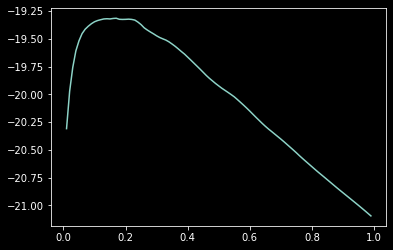

In [134]:
# Lasso regression
lass_r = Lasso(alpha=.17)
lass_r.fit(X_train, y_train)
np.mean(cross_val_score(lass_r, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3))


alpha = []
error = []
coef = []


for i in range(1,100):
    alpha.append(i/100)
    lasso = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lasso, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3)))

plt.plot(alpha, error)

err = list(zip(alpha, error))
df_err = pd.DataFrame(err, columns=["alpha","error"])
df_err[df_err.error == max(df_err.error)]



In [108]:
# Random Forest
rf = RandomForestRegressor()

np.mean(cross_val_score(rf, X_train, y_train, scoring= 'neg_mean_absolute_error', cv=3))

-14.865490309183201

In [120]:
# tune model gridsearchCV
parameters = {
    "n_estimators" : range(10, 30),
    "criterion" : ("mse", "mae"),
    "max_features" : ("auto", "sqrt", "log2")
}

gs = GridSearchCV(rf, parameters, scoring="neg_mean_absolute_error", cv=3, verbose=10)
gs.fit(X_train, y_train)

erion=mae, max_features=auto, n_estimators=27 ...............
[CV]  criterion=mae, max_features=auto, n_estimators=27, score=-14.693, total=   2.1s
[CV] criterion=mae, max_features=auto, n_estimators=28 ...............
[CV]  criterion=mae, max_features=auto, n_estimators=28, score=-16.602, total=   2.1s
[CV] criterion=mae, max_features=auto, n_estimators=28 ...............
[CV]  criterion=mae, max_features=auto, n_estimators=28, score=-16.304, total=   2.9s
[CV] criterion=mae, max_features=auto, n_estimators=28 ...............
[CV]  criterion=mae, max_features=auto, n_estimators=28, score=-14.770, total=   2.3s
[CV] criterion=mae, max_features=auto, n_estimators=29 ...............
[CV]  criterion=mae, max_features=auto, n_estimators=29, score=-16.006, total=   3.0s
[CV] criterion=mae, max_features=auto, n_estimators=29 ...............
[CV]  criterion=mae, max_features=auto, n_estimators=29, score=-15.805, total=   3.5s
[CV] criterion=mae, max_features=auto, n_estimators=29 ............

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'criterion': ('mse', 'mae'),
                         'max_features': ('auto', 'sqrt', 'log2'),
                         'n_estimators': range(10, 30)},
             scoring='neg_mean_absolute_error', verbose=10)

In [130]:
print(gs.best_score_)
print(gs.best_params_)
print(gs.best_estimator_)

-15.015975747320928
{'criterion': 'mse', 'max_features': 'auto', 'n_estimators': 20}
RandomForestRegressor(n_estimators=20)


In [166]:
# prediction

pred_lr = lr.predict(X_test)
pred_lasso = lass_r.predict(X_test)
pred_rf = gs.best_estimator_.predict(X_test)

In [167]:

print("lr error", mean_absolute_error(y_test, pred_lr))
print("lasso error", mean_absolute_error(y_test, pred_lasso))
print("rf error", mean_absolute_error(y_test, pred_rf))

lr error 19.02186027049196
lasso error 19.924713134502507
rf error 11.49496644295302
